In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d 

In [2]:
class watermaze(object):
    
    """
    This class defines a set of functions for simulating a rat moving in a water-maze.
    
    For the purposes of this assignment, you should be using the move function to 
    determine the next state of the environment at each time-step of the simulation.
    
    See the demo of its usage after the module code.
    """
    
    ####################################################################
    # the initialization function, measurements are in cm
    def __init__(self, pool_radius=60, platform_radius=10, platform_location=np.array([25,25]), 
                 stepsize=5.0, momentum=0.2, T=60):
        
        """
        The init function for the watermaze module.
        
        - The pool_radius argument specifies the radius of the pool.
        
        - The platform_radius argument specifies the radius of the platform.
        
        - The platform_location argument specifies the location of the platform centre.
        
        - The stepsize argument specifies how far the rat moves in one step.
        
        - The momentum argument specifies the ratio of old movement to new movement direction (i.e. 
        momentum = 0 means all new movement, momentum = 1 means all old movement, otherwise a mix.
        
        - The T argument is the maximum time for a trial in the pool.

        
        """
        
        # store the given info
        self.radius            = pool_radius
        self.platform_radius   = platform_radius
        self.platform_location = platform_location
        self.stepsize          = stepsize
        self.momentum          = momentum
        self.T                 = T
        
        # a dictionary for calculating directions
        self.direction = {
            0:  np.pi/2, #north
            1:  np.pi/4, #north-east
            2:  0, #east
            3:  7*np.pi/4, #south-east
            4:  3*np.pi/2, #south
            5:  5*np.pi/4, #south-west
            6:  np.pi, #west
            7:  3*np.pi/4, #north-west
        }
        
        # initialize the dynamic variables
        self.position = np.zeros((2,T))
        self.t        = 0
        self.prevdir  = np.zeros((2,))
        
    ####################################################################
    # for updating the rat's position in the pool
    def move(self, A):

        """
        Updates the simulated rat's position in the water-maze environment by moving it in the 
        specified direction. 
        
        - The argument A is the last selected action, and must be an integer from 0-7, with 0 indicating N, 
        1 indicating NE, etc. 

        """
        
        # check the A argument
        if (not np.isin(A, np.arange(8))):
            print('Error: The argument A must be an integer from 0-7, indicating which action was selected.')

        # determine the vector of direction of movement
        angle = self.direction[A]
        newdirection = np.array([np.cos(angle), np.sin(angle)])
        
        # add in momentum to reflect actual swimming dynamics (and normalize, then multiply by stepsize)
        direction = (1.0 - self.momentum)*newdirection + self.momentum*self.prevdir
        direction = direction/np.sqrt((direction**2).sum())
        direction = direction*self.stepsize
        
        # update the position, prevent the rat from actually leaving the water-maze by having it "bounce" off the wall 
        [newposition, direction] = self.poolreflect(self.position[:,self.t] + direction)

        # if we're now at the very edge of the pool, move us in a little-bit
        if (np.linalg.norm(newposition) == self.radius):
            newposition = np.multiply(np.divide(newposition,np.linalg.norm(newposition)),(self.radius - 1))

        # update the position, time (and previous direction)
        self.position[:,self.t+1] = newposition
        self.t                    = self.t + 1
        self.prevdir              = direction
        
    ####################################################################
    # for bouncing the rat off the wall of the pool
    def poolreflect(self, newposition):
        
        """
        The poolreflect function returns the point in space at which the rat will be located if it 
        tries to move from the current position to newposition but bumps off the wall of the pool. 
        If the rat would not bump into the wall, then it simply returns newposition. The function 
        also returns the direction the rat will be headed.
        """

        # determine if the newposition is outside the pool, if not, just return the new position
        if (np.linalg.norm(newposition) < self.radius):
            refposition  = newposition
            refdirection = newposition - self.position[:,self.t]

        else:

            # determine where the rat will hit the pool wall
            px = self.intercept(newposition)
            
            # get the tangent vector to this point by rotating -pi/2
            tx = np.asarray(np.matmul([[0, 1], [-1, 0]],px))

            # get the vector of the direction of movement
            dx = px - self.position[:,self.t]
            
            # get the angle between the direction of movement and the tangent vector
            theta = np.arccos(np.matmul((np.divide(tx,np.linalg.norm(tx))).transpose(),(np.divide(dx,np.linalg.norm(dx))))).item()

            # rotate the remaining direction of movement vector by 2*(pi - theta) to get the reflected direction
            ra = 2*(np.pi - theta)
            refdirection = np.asarray(np.matmul([[np.cos(ra), -np.sin(ra)], [np.sin(ra), np.cos(ra)]],(newposition - px)))

            # get the reflected position
            refposition = px + refdirection

        # make sure the new position is inside the pool
        if (np.linalg.norm(refposition) > self.radius):
            refposition = np.multiply((refposition/np.linalg.norm(refposition)),(self.radius - 1))

        return [refposition, refdirection]
    
    ####################################################################
    # for checking when/where the rat hits the edge of the pool
    def intercept(self,newposition):
        
        """
        The intercept function returns the point in space at which the rat will intercept with the pool wall 
        if it is moving from point P1 to point P2 in space, given the pool radius.
        """
        
        # for easy referencing, set p1 and p2
        p1 = self.position[:,self.t]
        p2 = newposition

        # calculate the terms used to find the point of intersection
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        dr = np.sqrt(np.power(dx,2) + np.power(dy,2))
        D  = p1[0]*p2[1] - p2[0]*p1[1]
        sy = np.sign(dy)
        if (sy == 0):
            sy = 1.0
            
        # calculate the potential points of intersection
        pp1 = np.zeros((2,))
        pp2 = np.zeros((2,))

        pp1[0] = (D*dy + sy*dx*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp2[0] = (D*dy - sy*dx*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp1[1] = (-D*dx + np.absolute(dy)*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp2[1] = (-D*dx - np.absolute(dy)*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))

        # determine which intersection point is actually the right one (whichever is closer to p2)
        if np.linalg.norm(p2 - pp1) < np.linalg.norm(p2 - pp2):
            px = pp1

        else:
            px = pp2
        
        return px
    
    ####################################################################
    # sets the start position of the rat in the pool
    def startposition(self):

        # select a random location from the main cardinal axes and calculate it's vector angle
        condition = 2*np.random.randint(0,4)
        angle = self.direction[condition]

        self.position[:,0] = np.asarray([np.cos(angle), np.sin(angle)]) * (self.radius - 1)
        
    ####################################################################
    # plot the most recent path of the rat through the pool
    def plotpath(self):
        
        # create the figure 
        fig = plt.figure()
        ax = fig.gca()

        # create the pool perimeter
        pool_perimeter = plt.Circle((0, 0), self.radius, fill=False, color='b', ls='-')
        ax.add_artist(pool_perimeter)

        # create theplatform
        platform = plt.Circle(self.platform_location, self.platform_radius, fill=False, color='r', ls='-')
        ax.add_artist(platform)

        # plot the path
        plt.plot(self.position[0,0:self.t],self.position[1,0:self.t], color='k', ls='-')

        # plot the final location and starting location
        plt.plot(self.position[0,0],self.position[1,0],color='b', marker='o',markersize=4, markerfacecolor='b')
        plt.plot(self.position[0,self.t-1],self.position[1,self.t-1],color='r', marker='o',markersize=6, markerfacecolor='r')

        # adjust the axis
        ax.axis('equal')
        ax.set_xlim((-self.radius-50, self.radius+50))
        ax.set_ylim((-self.radius-50, self.radius+50))
        plt.xticks(np.arange(-self.radius, self.radius+20, step=20))
        plt.yticks(np.arange(-self.radius, self.radius+20, step=20))
        ax.set_xlabel('X Position (cm)')
        ax.set_ylabel('Y Position (cm)')

        # turn on the grid
        plt.grid(True)
        plt.tight_layout()

        # show the figure
        plt.show()
        
    ####################################################################
    # checks whether the time is up
    def timeup(self):
        
        """
        Returns true if the time for the trial is finished, false otherwise.
        """
        
        return self.t > (self.T - 2)
    
    ####################################################################
    # checks whether the rat has found the platform
    def atgoal(self):
        
        """
        Returns true if the rat is on the platform, false otherwise.
        """
        
        return np.sqrt(np.sum((self.position[:,self.t] - self.platform_location)**2)) <= (self.platform_radius + 1)

Actor Critic and Combined Model Code

In [3]:
class models(object):

    def __init__(self,seed,learning_rate_actor,learning_rate_critic,discount_factor,coord_learning_rate=0.001):
        #numpy random seed
        np.random.seed(seed)

        #Number of place cells (as specified in paper)
        self.N = 493
        #place cell gaussian width (as specified in paper)
        self.sigma = 16
        #Lambda for place cell history used in coordinate model (as specified in paper)
        self.Lambda = 0.9
        
        #generate place cell center locations
        self.s = np.zeros([self.N,2])
        self.generate_s()

        #critic weights
        self.w = np.zeros(self.N)
        #actor weights
        self.z = np.zeros([8,self.N])
        #coordinate weights
        self.w_x = np.zeros(self.N)
        self.w_y = np.zeros(self.N)

        #learning rates
        self.learning_rate_actor = learning_rate_actor
        self.learning_rate_critic = learning_rate_critic
        self.coord_learning_rate = coord_learning_rate
        #discount factor for TD learning
        self.discount_factor = discount_factor 

        #goal coordinate memory
        self.goal_memory = []
        #coordinate action preference
        self.a_coord = 0
        

    #generate place cell centers vector s_i
    #generated using polar coordinates
    def generate_s(self):
        # radius of the environment
        radius = 60
        # random angles
        alpha = 2 * np.pi * np.random.random(self.N)
        # random radi
        r = radius * np.sqrt(np.random.random(self.N))
        # calculating coordinates
        self.s[:,0] = r * np.cos(alpha)
        self.s[:,1] = r * np.sin(alpha)

    #Eqn 1
    def activity(self,p): 
        #2-norm (euclidean distance)
        dist = np.linalg.norm(p - self.s,axis=1)
        #calculate density position
        dens = np.divide(dist**2, 2*(self.sigma**2))
        #return activation of place cells
        return np.exp(-dens)

    #Eqn 2
    #critic value function output (returns scalar)
    def critic_output(self,p):
        return np.dot(self.w,self.activity(p))

    #Eqn 2.2
    #actor policy output (returns a distribution over the actions)
    def actor_output(self,p):
        #by row!
        return np.dot(self.z,self.activity(p))

    #Eqn 2.3
    #x coordinate estimate
    def X_coord_output(self,p):
        return np.dot(self.w_x,self.activity(p))

    #Eqn 2.4
    #y coordinate estimate
    def Y_coord_output(self,p):
        return np.dot(self.w_y,self.activity(p))

    #Eqn 9
    #actor-critic policy for selecting an action
    def AC_policy(self,a_j):
        S = np.sum(np.exp(2*a_j))
        p_j = np.divide(np.exp(2*a_j),S)
        return np.random.choice(len(p_j), p=p_j) 

    #move in environment
    #helper function to keep algorithm methods more organized
    def move(self,maze,A,t):
        #move in maze
        maze.move(A) 
        #get new position
        p_t_1 = maze.position[:,t+1]
        #calculate reward
        reward = 0
        if maze.atgoal():
            reward = 1 
        return (p_t_1, reward)

    #eqn 8
    #update critic value function
    def critic_update(self,delta,p):
        self.w += self.learning_rate_critic * delta * self.activity(p)
    
    #eqn 10
    #update actor policy
    def actor_update(self,delta,p,A):
        #eqn 10
        g = np.zeros(8)
        g[A] = 1
        self.z += self.learning_rate_actor * delta * np.outer(g,self.activity(p))

    #update coordinate action preference
    def a_coord_update(self,delta):
        self.a_coord += 75 * self.learning_rate_actor * delta
    
    #Summation in Eqn 11 and 12
    #update trace (history of activations)
    def trace_update(self,trace,p):
        return ((trace * self.Lambda) + self.activity(p))

    #Eqn 11 and 12
    #update coordinate model
    def coord_update(self,p_t,p_t_1,trace):
        delta_x = p_t[0] - p_t_1[0]
        delta_y = p_t[1] - p_t_1[1]
        self.w_x += self.coord_learning_rate * (delta_x + self.X_coord_output(p_t_1) - self.X_coord_output(p_t))*trace
        self.w_y += self.coord_learning_rate * (delta_y + self.Y_coord_output(p_t_1) - self.Y_coord_output(p_t))*trace

    #given direction vector, calculate optimal action
    #used for coordinate model
    def coordinate_action(self,x1):
        x2 = np.array([0,1])
        dot = np.dot(x1,x2)      # dot product
        det = np.linalg.det([x1,x2])     # determinant
        angle = np.math.atan2(det, dot) 
        if angle < 0:
            angle += 2*np.pi
        action = int(round(np.divide(angle,np.pi/4)))
        if action == 8:
            action = 0
        return action

    #coordinate model control
    #If we have a goal memory, move towards goal memory
    #If we have no goal memory, move randomly
    def coordinate_control(self,p):
        if len(self.goal_memory) != 0:
            cur_pos = [self.X_coord_output(p),self.Y_coord_output(p)]
            x1 = np.subtract(self.goal_memory,cur_pos)
            a = self.coordinate_action(x1)
            return a
        return np.random.randint(8)

###################################################################################################################################
#Actor-critic method
###################################################################################################################################
    def AC(self,maze):
        #set start position in maze
        maze.startposition()
        #set time
        t = 0
        #get initial agent position
        p_t = maze.position[:,t]
        #path distance
        distance = 0
        
        #continute until agent finds goal or runs out of time
        while not (maze.atgoal() or maze.timeup()):
            #get agent action preferences using actor
            a_j = self.actor_output(p_t)
            #choose action using softmax distribution over preferences
            A = self.AC_policy(a_j)
            #take action in environment
            p_t_1,reward = self.move(maze,A,t)    

            #calculate TD error (Eqn 7)
            #reward and C(p_t_1) are never both non zero!
            if reward == 1:
                delta = reward - self.critic_output(p_t)
            else:
                delta = (self.discount_factor * self.critic_output(p_t_1)) - self.critic_output(p_t)

            #Compute actor and critic weight updates
            self.critic_update(delta,p_t)
            self.actor_update(delta,p_t,A)

            #update time, distance and position
            t += 1
            distance += np.linalg.norm(p_t_1-p_t)
            p_t = p_t_1

        #return time and distance of episode
        return (t,distance)

###################################################################################################################################
#Combined coordinate and actor-critic algorithm
###################################################################################################################################
    def coord(self,maze):
        #set start position in maze
        maze.startposition()
        #set time
        t = 0
        #get initial agent position
        p_t = maze.position[:,t]
        #path distance
        distance = 0

        #decaying sum of activations
        trace = np.zeros(self.N)
        #coordinate action counter (only for debugging and graphing)
        a_coord_n = 0

        #continute until agent finds goal or runs out of time
        while not (maze.atgoal() or maze.timeup()):
            #get agent action preferences using actor
            #add coordinate action preference
            a_j = self.actor_output(p_t)
            a_j = np.append(a_j,self.a_coord)
            #choose action using softmax distribution over preferences
            A = self.AC_policy(a_j)
            
            #If coordinate action selected, compute what action the coordinate model specifies
            a_coord_taken = False
            if A == 8:
                A = self.coordinate_control(p_t)
                a_coord_taken = True
                a_coord_n += 1                
            
            #Take action in environment
            p_t_1,reward = self.move(maze,A,t)    

            #calculate TD error (Eqn 7)
            #reward and C(p_t_1) are never both non zero!
            if reward == 1:
                delta = reward - self.critic_output(p_t)
            else:
                delta = (self.discount_factor * self.critic_output(p_t_1)) - self.critic_output(p_t)

            #Update trace (decaying sum of activations), critic weights, X and Y coordinate weights
            trace = self.trace_update(trace,p_t)
            self.critic_update(delta,p_t)
            self.coord_update(p_t,p_t_1,trace)
            #Update coordinate action preference if agent choose the coordinate action and have a goal memory
            #Update actor weights if agent did not select the coordinate action
            if a_coord_taken:
                if len(self.goal_memory) != 0:
                    self.a_coord_update(delta)
            else:
                self.actor_update(delta,p_t,A)

            #update time, distance and position            
            t += 1
            distance += np.linalg.norm(p_t_1-p_t)
            p_t = p_t_1

        #Update goal memory
        if reward == 1:
            self.goal_memory = [self.X_coord_output(p_t),self.Y_coord_output(p_t)]
        else:
            self.goal_memory = []

        #return time, distance and number of times coordinate action was selected in the episode
        return (t,distance,a_coord_n)


###################################################################################################################################
#functions for debugging
################################################################################################################################### 
    def debug_coord_x(self):
        x = np.arange(-60,60)
        y = np.arange(-60,60)

        values = np.zeros([120,120])

        for i in x:
            for j in y:
                values[i+60,j+60] = self.X_coord_output([i,j])

        plt.imshow(values, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.show()


    def debug_coord_y(self):
        x = np.arange(-60,60)
        y = np.arange(-60,60)

        values = np.zeros([120,120])

        for i in x:
            for j in y:
                values[i+60,j+60] = self.Y_coord_output([i,j])

        plt.imshow(values, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.show()


    def debug(self):
        x = np.arange(-60,60)
        y = np.arange(-60,60)

        values = np.zeros([120,120])

        for i in x:
            for j in y:
                values[i+60,j+60] = self.critic_output([i,j])

        plt.imshow(values, cmap='hot', interpolation='nearest')
        #plt.colorbar()
        plt.show()

Part 2: Actor-Critic Experiments

In [4]:
##########################################################################################
#Multi platform flag
##########################################################################################
multi_platform_AC = True

#define platforms
if multi_platform_AC:
    platforms = np.array([[25,25],[-10,-15],[-20,25],[15,-35],[40,35]])
else:
    platforms = np.array([[25,25]])

#Model parameters
learning_rate_actor = 0.1
learning_rate_critic = 0.01
discount_factor = 0.9

#number of platforms
num_platforms = len(platforms)
#number of maze trials (per platform)
trials = 50
#number of simulation runs (random seeds)
if multi_platform_AC:
    runs = 10
else:
    runs = 50

#time data
time_data = np.zeros([runs,num_platforms*trials])
#distance data
distance_data = np.zeros([runs,num_platforms*trials])
#random seeds
seeds = np.arange(runs)

for seed in seeds:
    #create model
    model = models(seed,learning_rate_actor,learning_rate_critic,discount_factor)

    #for each platform run actor critic model for set number of trials
    #save time and distance information from episode
    for i in range(len(platforms)):
        for j in range(trials):
            ###############################################################
            #create maze
            maze = watermaze(platform_location=platforms[i])
            #Call AC method in code block above (this runs actor critic)
            time,distance = model.AC(maze)
            ###############################################################
            distance_data[seed,(i*trials)+j] = distance
            time_data[seed,(i*trials)+j] = time

print(time_data.shape)
#compute time and distance mean and standard deviation across random seeds
time_mean = np.mean(time_data,axis=0)
time_std = np.std(time_data,axis=0)
distance_mean = np.mean(distance_data,axis=0)
distance_std = np.std(distance_data,axis=0)

(10, 250)


<function matplotlib.pyplot.show(*args, **kw)>

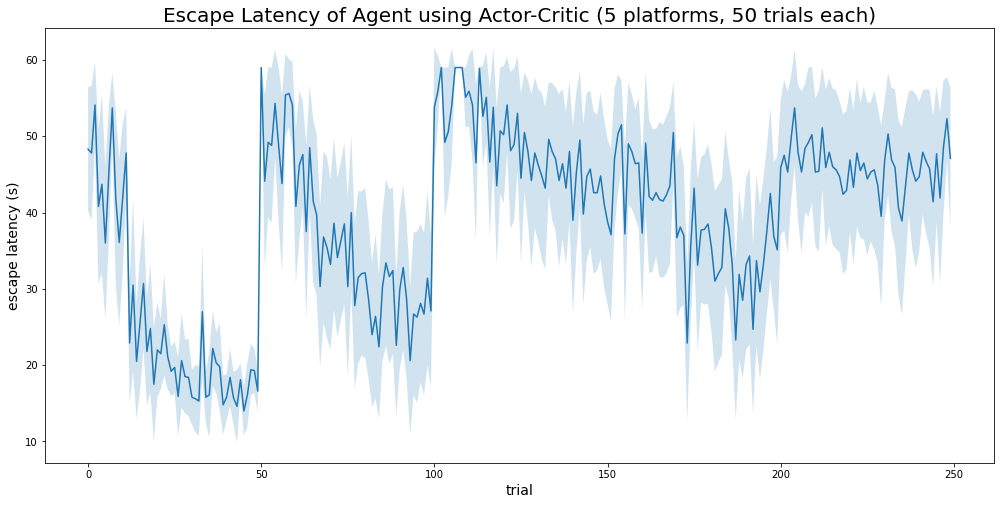

In [5]:
#Plotting code
x = np.arange(len(time_mean))
plt.figure(figsize=(17,8))

if multi_platform_AC:   
    plt.title('Escape Latency of Agent using Actor-Critic (' + str(num_platforms) + ' platforms, '+str(trials)+' trials each)', fontsize=20)
else:
    plt.title('Escape Latency of Agent using Actor-Critic (1 platform)', fontsize=20)

plt.xlabel('trial',fontsize=14)
plt.ylabel('escape latency (s)',fontsize=14)
plt.plot(x,time_mean)
plt.fill_between(x,time_mean-time_std/2,time_mean+time_std/2,alpha=0.2)

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

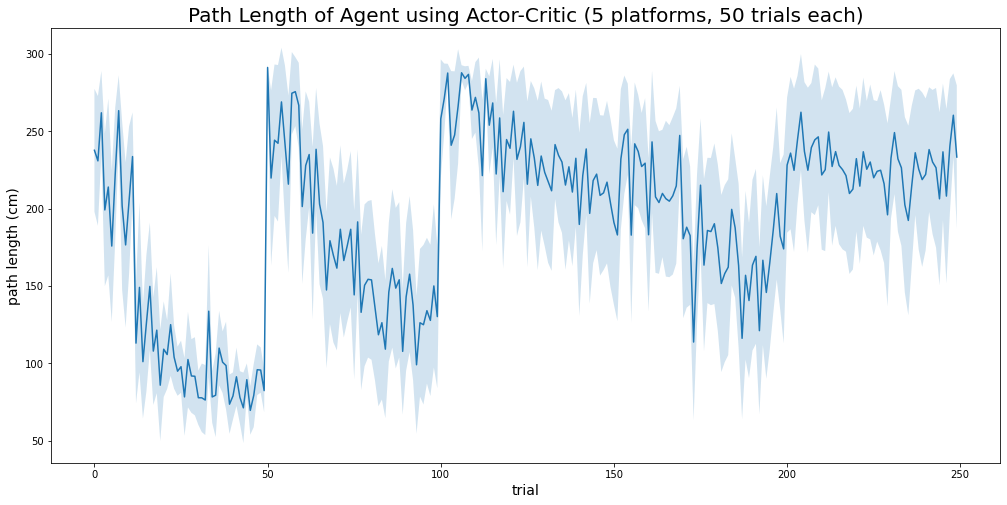

In [6]:
#Path length!!
#Not included in report because its almost the exact same plot as escape latency, just with a different y axis scale

x = np.arange(len(distance_mean))
plt.figure(figsize=(17,8))

if multi_platform_AC:   
    plt.title('Path Length of Agent using Actor-Critic (' + str(num_platforms) + ' platforms, '+str(trials)+' trials each)', fontsize=20)
else:
    plt.title('Path Length of Agent using Actor-Critic (1 platform)', fontsize=20)

plt.xlabel('trial',fontsize=14)
plt.ylabel('path length (cm)',fontsize=14)
plt.plot(x,distance_mean)
plt.fill_between(x,distance_mean-distance_std/2,distance_mean+distance_std/2,alpha=0.2)

plt.show

Part 3: Combined Model Experiments

In [7]:
##########################################################################################
#Multi platform flag
##########################################################################################
multi_platform = True

#define platforms
if multi_platform:
    platforms = np.array([[25,25],[-10,-15],[-20,25],[15,-35],[40,35]])
else:
    platforms = np.array([[25,25]])

#Model parameters
learning_rate_actor = 0.1
learning_rate_critic = 0.01
discount_factor = 0.99
coord_learning_rate = 0.001

#number of platforms
num_platforms = len(platforms)
#number of maze trials (per platform)
trials = 50
#number of simulation runs (random seeds)
runs = 10

#distance data
distance_data = np.zeros([runs,num_platforms*trials])
#time data
time_data = np.zeros([runs,num_platforms*trials])
#frequency of a_coord (Used for debugging and to replicate figure 6e from paper)
a_coord_freq = np.zeros([runs,num_platforms*trials])

#random seeds
seeds = np.arange(runs)

for seed in seeds:
    #create model
    model = models(seed,learning_rate_actor,learning_rate_critic,discount_factor,coord_learning_rate)

    #for each platform run model for set number of trials
    #save data from each episode
    for i in range(len(platforms)):
        for j in range(trials):
            ###############################################################
            #create maze
            maze = watermaze(platform_location=platforms[i])
            #Call coord method in code block above (this runs combined model)
            time,distance,a_coord_n = model.coord(maze)
            ###############################################################
            distance_data[seed,(i*trials)+j] = distance
            time_data[seed,(i*trials)+j] = time
            a_coord_freq[seed,(i*trials)+j] = 1.0*a_coord_n/time

        #model.debug_coord_x()
        #model.debug_coord_y()

#compute time and distance mean and standard deviation across random seeds
time_mean = np.mean(time_data,axis=0)
time_std = np.std(time_data,axis=0)
distance_mean = np.mean(distance_data,axis=0)
distance_std = np.std(distance_data,axis=0)
a_coord_mean = np.mean(a_coord_freq,axis=0)